In [1]:
%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))


['train.csv', 'sample_submission.csv', 'test.csv']


In [3]:
import mlxtend
import pandas_profiling

import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import matplotlib.pyplot as plt


from tqdm import tqdm


/opt/conda/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/lib/python3.6

In [4]:
%%time
train_df = pd.read_csv("../input/train.csv")


CPU times: user 3.32 s, sys: 268 ms, total: 3.58 s
Wall time: 3.58 s


In [5]:
train_df.shape

(4459, 4993)

In [6]:
TRAIN_SIZE = train_df.shape[0]

In [7]:
%%time
test_df = pd.read_csv("../input/test.csv",
                     nrows=TRAIN_SIZE)


CPU times: user 3.86 s, sys: 184 ms, total: 4.04 s
Wall time: 4.05 s


# defining useful functions

In [8]:

%matplotlib inline

import os

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew #for some statistics

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve

import mlxtend
from mlxtend.plotting import plot_learning_curves

import pandas_profiling





def checkNaValues(dataframe):
    """check nan values in dataframe"""
    
    print("\n# Is there any nan values?: ", dataframe.isna().all().all())
    
    print("## detail missing data ratio")
    #if dataframe.isna().all().all()
    dataframe_na = (dataframe.isna().sum()/len(dataframe))*100
    print(dataframe_na)
    dataframe_na = dataframe_na.drop(
        dataframe_na[dataframe_na == 0].index
    ).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio':dataframe_na})
    print(missing_data)
    
    
    """there is error. so not implemented yet
    # just plot the rate
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=dataframe_na.index, y=dataframe_na.values)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    """

    
def checkObjTypeColumns(dataframe):
    """Check object dtype columns"""

    print("\n# object dtype columns")
    # object dtypeの列名からその列のデータのみを抽出
    df_object_type = dataframe[dataframe.select_dtypes(['object']).columns]
    #df_object_type = dataframe[[x for x in dataframe.columns if dataframe[x].dtypes == "object"]]
    print(df_object_type.head())
    #print(df_object_type.info()) # not useful info
    print(df_object_type.describe())

    
def checkValueCounts(dataframe):
    """check value counts of each features and find boolean feature or not."""

    print("# value_counts of each feature: ")
    for column in dataframe.columns:
        #print("## ", column, ": ")
        #print(dataframe[column].value_counts().head())
        value_counts = dataframe[column].value_counts().shape[0]
        if value_counts == 1:
            print(column, " -> single value. value count:  ", dataframe[column].value_counts().shape[0])            
        elif value_counts == 2:
            print(column, " -> maybe boolean. value count:  ", dataframe[column].value_counts().shape[0])
        else:
            print(column, " -> not boolean. value count:  ", dataframe[column].value_counts().shape[0])
            

def findSingleValueColmuns(dataframe):
    """check value counts of each features and find single value feature.
    Such column is no meaning to learn.
    """

    single_val_columns = []
    for column in dataframe.columns:
        value_counts = dataframe[column].value_counts().shape[0]
        if value_counts == 1:
            single_val_columns.append(column)
    return single_val_columns

            
def checkCorrelationOfFeatures(dataframe):
    """check correlation matix of each features"""

    # plot corr
    print("\n# correlation matrix")
    corrmat = dataframe.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, square=True)
    plt.show()
    print(corrmat)
    print()
    
    corr_values = corrmat.iloc[0]
    print("## highest correlation: ", corr_values.sort_values().head())
    print("## lowest correlation: ", corr_values.sort_values().tail())

    
def checkSkewness(dataframe):
    """check skewness of each features"""
    
    #numeric_feats = dataframe.dtypes[all_data.dtypes != "object"].index
    numeric_feats = dataframe.select_dtypes(exclude=['object'])
    #print(numeric_feats)
    # Check the skew of all numerical features
    skewed_feats = numeric_feats.apply(
        lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\n# Skew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    print(skewness)
    
    return skewness
    
    
def checkAllDataInfo(dataframe):
    """print all dataframe info"""

    print(dataframe.head())
    print("\n# shape: ", dataframe.shape)
    print("\n# columns names: ", train_df.columns.values)
    
    print("\n# df.info(): ")
    print(dataframe.info())
    #print("\n# counts dtypes: \n", dataframe.dtypes.value_counts())# it is included in dataframe.info()

    print("\n# df.describe(): ")
    print(dataframe.describe())
    print()
    
    #print()
    #pandas_profiling.ProfileReport(dataframe)
    print()
    checkNaValues(dataframe)
    print()
    checkObjTypeColumns(dataframe)
    print()
    checkValueCounts(dataframe)
    print()
    #checkCorrelationOfFeatures(dataframe)
    
    print()
    checkSkewness(dataframe)
    
    
    
def my_plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        scoring="r2",
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



def checkTargetInfo(dataframe, target_name="y"):
    """print target y value info"""
 
    # plot distribution
    sns.distplot(train_df[target_name], fit=norm)
    (mu, sigma) = norm.fit(train_df[target_name])
    print("mu, sigma:", mu, sigma)

    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('target value distribution')

    
    # plot skewness

    #print("skewness of y", skew(dataframe[target_name]))
    print("skewness of y", train_df[target_name].skew())
    fig = plt.figure()
    res = stats.probplot(train_df[target_name], plot=plt)
    plt.show()

    
    
def checkCorrelationOfSelectedFeatures(dataframe, columns):
    """check correlation matix of each features"""

    # plot corr
    print("\n# correlation matrix")
    corrmat = dataframe[columns].corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)
    plt.show()
    print(corrmat)
    

    
def splitToIdTargetFeatures(dataframe, id_name, target_name):
    """split train df to data, id and taret dataframes
    """
    id_df = dataframe[id_name]
    target_df = dataframe[target_name]
    features_df = dataframe.drop([id_name, target_name], axis=1)
    
    return id_df, target_df, features_df




# EDA

## general info

## checking in details

## checkTargetInfo

### apply logarithm transformation to tareget

14.490239292748585 1.7507504829494496


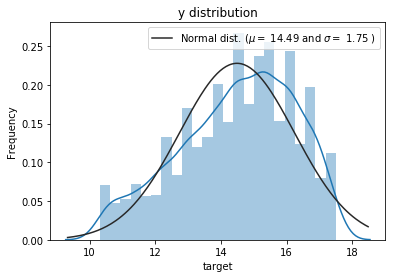

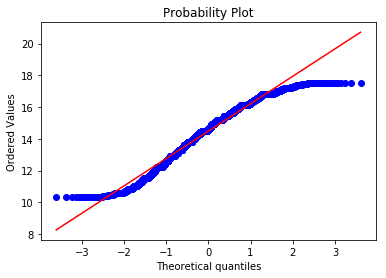

In [9]:
# apply logarithm transformation

train_df["target"] = np.log1p(train_df["target"])
sns.distplot(train_df["target"], fit=norm)

(mu, sigma) = norm.fit(train_df["target"])
print(mu, sigma)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(train_df["target"], plot=plt)
plt.show()


## pairplot

- not good idea to make function
- better to use pairplot() directly. more useful.

## pandas_profiling

----

# feature eng

## add some features before drop some columns


### add sum of zeros feature

In [16]:
def add_SumZeros(train, test):
    flist = [x for x in train.columns if not x in ['ID','target']]
    train.insert(1, 'SumZeros', (train[flist] == 0).astype(int).sum(axis=1))
    test.insert(1, 'SumZeros', (test[flist] == 0).astype(int).sum(axis=1))
    return train, test


In [17]:
%%time
train_df, test_df = add_SumZeros(train_df, test_df)


CPU times: user 1.32 s, sys: 604 ms, total: 1.93 s
Wall time: 1.93 s


In [18]:
train_df.SumZeros

0       4889
1       4924
2       4973
3       4969
4       4965
5       4230
6       4855
7       4961
8       4768
9       4942
10      4920
11      4918
12      4938
13      4641
14      4987
15      4967
16      4943
17      4748
18      4887
19      4817
20      4905
21      4709
22      4681
23      4796
24      4971
25      4792
26      4951
27      4887
28      4827
29      4895
        ... 
4429    4787
4430    4973
4431    4790
4432    4980
4433    4529
4434    4777
4435    4884
4436    4867
4437    4927
4438    4901
4439    4915
4440    4782
4441    4974
4442    4903
4443    3650
4444    4948
4445    4930
4446    4970
4447    4979
4448    4933
4449    4981
4450    4966
4451    4975
4452    4986
4453    4989
4454    4882
4455    4874
4456    4799
4457    4937
4458    4860
Name: SumZeros, Length: 4459, dtype: int64

In [19]:
test_df.SumZeros

0       4913
1       4979
2       4892
3       4871
4       4983
5       4969
6       4966
7       4984
8       4963
9       4843
10      4882
11      4988
12      4949
13      4968
14      4951
15      4694
16      4943
17      4886
18      4956
19      4931
20      4987
21      4972
22      4969
23      4983
24      4948
25      4920
26      4966
27      4937
28      4925
29      4971
        ... 
4429    4943
4430    4965
4431    4967
4432    4979
4433    4977
4434    4913
4435    4969
4436    4947
4437    4952
4438    4989
4439    4914
4440    4986
4441    4989
4442    4971
4443    4964
4444    4957
4445    4959
4446    4917
4447    4923
4448    4988
4449    4982
4450    4990
4451    4925
4452    4951
4453    4979
4454    4886
4455    4967
4456    4930
4457    4961
4458    4861
Name: SumZeros, Length: 4459, dtype: int64

### add sum of values

In [20]:
def add_SumValues(train, test):
    flist = [x for x in train.columns if not x in ['ID','target']]
    
    train.insert(1, 'SumValues', (train[flist] != 0).astype(int).sum(axis=1))
    test.insert(1, 'SumValues', (test[flist] != 0).astype(int).sum(axis=1))

    return train, test

In [21]:
%%time
train_df, test_df = add_SumValues(train_df, test_df)


CPU times: user 1.37 s, sys: 628 ms, total: 2 s
Wall time: 2 s


In [22]:
train_df.SumValues

0        103
1         68
2         19
3         23
4         27
5        762
6        137
7         31
8        224
9         50
10        72
11        74
12        54
13       351
14         5
15        25
16        49
17       244
18       105
19       175
20        87
21       283
22       311
23       196
24        21
25       200
26        41
27       105
28       165
29        97
        ... 
4429     205
4430      19
4431     202
4432      12
4433     463
4434     215
4435     108
4436     125
4437      65
4438      91
4439      77
4440     210
4441      18
4442      89
4443    1342
4444      44
4445      62
4446      22
4447      13
4448      59
4449      11
4450      26
4451      17
4452       6
4453       3
4454     110
4455     118
4456     193
4457      55
4458     132
Name: SumValues, Length: 4459, dtype: int64

In [23]:
test_df.SumValues

0        79
1        13
2       100
3       121
4         9
5        23
6        26
7         8
8        29
9       149
10      110
11        4
12       43
13       24
14       41
15      298
16       49
17      106
18       36
19       61
20        5
21       20
22       23
23        9
24       44
25       72
26       26
27       55
28       67
29       21
       ... 
4429     49
4430     27
4431     25
4432     13
4433     15
4434     79
4435     23
4436     45
4437     40
4438      3
4439     78
4440      6
4441      3
4442     21
4443     28
4444     35
4445     33
4446     75
4447     69
4448      4
4449     10
4450      2
4451     67
4452     41
4453     13
4454    106
4455     25
4456     62
4457     31
4458    131
Name: SumValues, Length: 4459, dtype: int64

In [ ]:
## add 

## remove single value column

In [ ]:
single_val_columns = findSingleValueColmuns(train_df)

In [ ]:
print("drop single value columns, ", len(single_val_columns), "columns were dropped")

In [ ]:
print("train_df.shape, test_df.shape")
print(train_df.shape, test_df.shape)

train_df.drop(single_val_columns, axis=1, inplace=True)
test_df.drop(single_val_columns, axis=1, inplace=True)

print(train_df.shape, test_df.shape)

## remove dupulicate column

remove if train_df data is same even if test_df data is not same.
because if train_df data is same, it cannot learn the differece.

comment out to reduce time

In [ ]:
colsToRemove =  ['d60ddde1b', 'acc5b709d', 'f333a5f60', 'f8d75792f', '912836770', 'f333a5f60']
colsScaned =  ['d60ddde1b', 'acc5b709d', 'f333a5f60', 'f8d75792f', '912836770']
dupList =  {'34ceb0081': ['d60ddde1b'], '8d57e2749': ['acc5b709d', 'f333a5f60'], '168b3e5bc': ['f8d75792f'], 'a765da8bc': ['912836770']}

In [ ]:
print("train_df.shape, test_df.shape")
print(train_df.shape, test_df.shape)

train_df.drop(colsToRemove, axis=1, inplace=True)
test_df.drop(colsToRemove, axis=1, inplace=True)

print(train_df.shape, test_df.shape)

## check Correlation and reduce high corr features

- if a feature have only one value, correlation become NAN.
- so better to check correlation after dropped one value features

In [12]:
%%time
corrmat = train_df.corr(method="spearman")

CPU times: user 1h 50min 42s, sys: 1.17 s, total: 1h 50min 43s
Wall time: 1h 50min 47s


In [13]:
corrmat.shape

(4992, 4992)

In [27]:
corrmat.head()

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,...,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
target,1.000000,-0.091119,0.011424,0.001637,0.008396,0.012453,-0.041327,0.000845,-0.029482,0.073270,-0.004677,-0.052527,0.025713,0.009263,0.020584,0.043034,0.005428,-0.012779,-0.045644,-0.023326,-0.016305,0.029623,-0.022630,0.024510,0.012243,-0.025754,0.014046,NaN,-0.051988,-0.005774,0.013118,-0.014600,-0.043908,0.009267,NaN,-0.016702,0.000026,NaN,0.072787,-0.030116,...,0.013616,-0.016024,-0.034372,-0.083945,0.007098,0.016091,0.020301,0.002883,0.007206,-0.037815,-0.028778,-0.028888,0.026874,-0.010747,0.000070,-0.030295,0.001844,0.009560,0.021140,0.019779,-0.050557,0.022751,-0.010236,-0.005334,0.022224,-0.037075,-0.033407,-0.004608,0.009654,0.010799,-0.046171,-0.033835,-0.033887,0.010295,-0.021844,-0.012320,-0.009181,-0.008665,-0.020763,-0.028219
48df886f9,-0.091119,1.000000,-0.002815,0.103751,-0.001990,-0.003147,-0.009695,-0.003147,0.140365,0.018468,0.012951,0.032313,-0.001407,-0.003448,-0.013792,0.007757,0.018913,0.024785,0.026919,0.053076,0.023951,-0.008823,0.028694,-0.012614,-0.016340,0.092760,-0.002815,NaN,0.136418,-0.008823,0.042655,-0.004453,0.124354,-0.016968,NaN,0.043942,-0.003915,NaN,-0.012606,-0.005714,...,0.033262,0.004308,0.043486,0.200826,-0.001990,-0.012033,-0.017498,0.010685,-0.017582,0.041107,0.007462,0.000440,-0.012641,-0.002815,-0.001407,-0.005079,-0.006145,-0.014371,-0.018980,-0.004224,0.072888,-0.001407,-0.016468,0.019291,-0.008111,0.025858,-0.023401,-0.001407,-0.007986,-0.014657,0.050793,-0.007023,0.021959,-0.018409,0.159803,-0.008355,-0.005980,-0.008234,0.023135,-0.018293
0deb4b6a8,0.011424,-0.002815,1.000000,-0.002587,-0.000635,-0.001004,-0.003093,0.222477,-0.001004,-0.006577,-0.005046,-0.005872,-0.000449,-0.001100,-0.010848,-0.005779,-0.002665,-0.002250,0.020900,-0.002382,-0.002339,0.077240,-0.002061,-0.004024,-0.005212,-0.001490,-0.000898,NaN,0.026207,-0.002815,-0.011322,-0.001421,-0.013346,-0.008254,NaN,-0.006774,-0.005512,NaN,-0.013441,0.008781,...,-0.001854,-0.004152,-0.006758,-0.004101,-0.000635,-0.003839,-0.008394,0.015368,0.037163,-0.009380,-0.012251,-0.006791,-0.009186,-0.000898,-0.000449,-0.001620,0.113534,-0.004584,-0.006055,-0.001348,-0.004276,-0.000449,-0.005253,0.042967,-0.002587,-0.008490,0.006032,-0.000449,-0.002548,-0.004675,-0.007912,-0.006232,-0.012793,-0.005872,-0.000449,-0.002665,-0.001908,0.083316,-0.004050,-0.005835
34b15f335,0.001637,0.103751,-0.002587,1.000000,-0.001829,-0.002893,-0.008912,-0.002893,-0.002893,0.019102,0.017999,0.037439,0.172196,-0.003170,-0.022559,-0.016654,0.022023,-0.006484,-0.005481,-0.006864,-0.006740,-0.008111,0.032501,-0.011596,-0.015020,-0.004294,-0.002587,NaN,0.089786,-0.008111,-0.002398,-0.004094,0.013821,-0.003145,NaN,0.017236,-0.001134,NaN,0.010182,-0.006988,...,-0.005342,0.007467,-0.007759,0.084909,-0.001829,-0.011061,-0.013793,-0.004028,-0.016163,0.001244,0.025370,-0.019569,-0.026471,0.172372,-0.001293,-0.004669,-0.005648,0.004486,0.023772,-0.003883,0.024958,-0.001293,0.015614,-0.029122,-0.007456,-0.004909,-0.021524,-0.001293,-0.007341,0.021694,0.049965,-0.017959,0.007049,-0.016922,-0.001293,-0.007680,-0.005497,0.022141,-0.011670,-0.002537
a8cb14b00,0.008396,-0.001990,-0.000635,-0.001829,1.000000,-0.000710,-0.002186,-0.000710,-0.000710,-0.014631,-0.003567,-0.00415

In [41]:
corrmat["target"].sort_values(ascending=False).head(10)

target       1.000000
f190486d6    0.107678
58e2e02e6    0.092589
9fd594eec    0.085647
e1d0e11b5    0.081320
0d51722ca    0.077310
63c094ba4    0.075535
ddea5dc65    0.074479
1c71183bb    0.074004
20aa07010    0.073270
Name: target, dtype: float64

In [42]:
corrmat["target"].sort_values(ascending=False).tail(10)

d196ca1fd   NaN
a8e562e8e   NaN
eb6bb7ce1   NaN
5beff147e   NaN
52b347cdc   NaN
4600aadcf   NaN
6fa0b9dab   NaN
43d70cc4d   NaN
408021ef8   NaN
e29d22b59   NaN
Name: target, dtype: float64

## combine train/test to all_data

In [ ]:
ntrain = train_df.shape[0]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)

all_id, all_target, all_data = splitToIdTargetFeatures(all_data, id_name="ID", target_name="target")


In [ ]:
all_data.head()

In [ ]:
all_id.head()

In [ ]:
all_target.head()

## skew feature

In [ ]:
skewness = checkSkewness(all_data)
skewness.head(5)

In [ ]:
skewness.tail(5)

## Box Cox Transformation of (highly) skewed features



In [ ]:
skewnessBig = skewness[abs(skewness) > 0.75]
print("feature num {}\nskewed feature number: {}".format(skewness.shape[0], 
                                                         skewnessBig.shape[0]))

from scipy.special import boxcox1p

skewed_features = skewnessBig.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)


In [ ]:
all_data.apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)

----

# prepare train/test data

In [ ]:
id_train_df, y_train_df, X_train_df = splitToIdTargetFeatures(train_df,
                                                              id_name="ID",
                                                              target_name="target")

In [ ]:
print(id_train_df.head())
print(y_train_df.head())
print(X_train_df.head())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, y_train_df, 
    test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)


# base model

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA

from hyperopt import hp, tpe, Trials, fmin

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from mlxtend.regressor import StackingRegressor

## Defined find best parameter function by hyperopt module

### give model for hyperopt my funcs

In [ ]:
count_hyperopt = 0

def hyperopt_objective(model, X_train, y_train, scoring="r2", cv_size=5, n_jobs=3):
    """return objective function for hyperopt"""

    def objective(args):
        global count_hyperopt
        print("Trial ", count_hyperopt, ", Params ", args, " -> ", end="")
        
#        print(model.steps[-1])
        model.steps[-1][1].set_params(**args)

        score = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv_size, n_jobs=n_jobs)
        
        print("Done")
        count_hyperopt += 1
        
        return -score.mean()

    return objective





def searchHyperParam(model, par_space, X_train, y_train, scoring="r2", max_evals=100, cv_size=5, n_jobs=3):
    """search hyper parameter of a selected model"""

    
    global count_hyperopt
    count_hyperopt = 0
    
    objective = hyperopt_objective(model, X_train, y_train, scoring=scoring, cv_size=cv_size, n_jobs=n_jobs)
    
    #best_params = findBestParm(objective, par_space, X_train, y_train, scoring=scoring, max_evals=max_evals)

    trials = Trials()

    best = fmin(
        objective, 
        par_space, # 探索するパラメータのdictもしくはlist
        algo=tpe.suggest, # どのロジックを利用するか、基本的にはtpe.suggestでok
        max_evals=max_evals,
        trials=trials,
        #verbose=1
    )
    print("best par: ", best)
    print("best trial: ", trials.best_trial["result"])
    #print("trials losses: ", trials.losses())

    count_hyperopt = 0
    
    return best


def evalModelByCV(model, X_train, y_train):
    """evaluate model by cross validation"""
    
    score = cross_val_score(model, X_train, y_train, scoring="r2", cv=5)

    print("model score: {:f} ({:f})\n" .format(
        score.mean(), score.std()))
    print("all scores: ", score)

    
def plot_my_learning_curves(X_train, y_train, X_test, y_test, model, scoring="r2", cv=5, n_jobs=3):
    """plot learning curves by mlxtend and my func my_plot_learning_curve()"""
    plot_learning_curves(X_train, y_train, X_test, y_test, 
                     model, scoring=scoring)
    plt.show()
    
    title = "Learning Curves"
    my_plot_learning_curve(model, title, 
                        X_train, y_train,
                        #ylim=(0.7, 1.01), 
                        cv=cv, scoring=scoring,
                        n_jobs=n_jobs)
    plt.show()

    
    

### give model_name for hyperopt my funcs

** NOT ACCTIVATED !!!**

## Def hyperopt param

In [ ]:
cv_size = 5
#max_evals = 100
max_evals = 20
n_jobs = 1

## SVR

In [ ]:
svr = make_pipeline(
    PCA(n_components=1000),
    RobustScaler(),
    SVR()

)

kernel_list = [
    'rbf',
#    'poly',
    'sigmoid']
par_space = {
    'C':hp.loguniform('C', -8, 2),
    'gamma':hp.loguniform('gamma', -8, 2),
    'epsilon':hp.loguniform('epsilon', -8, 2),
    'kernel':hp.choice('kernel', kernel_list)
}


In [ ]:
%%time
best_params = searchHyperParam(svr, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params["kernel"] = kernel_list[best_params["kernel"]]
print(best_params)


In [ ]:
best_params = {'C': 6.0125849233435975,
 'epsilon': 0.018596343856883617,
 'gamma': 0.019396603678872793,
 'kernel': 'rbf'}

In [ ]:
svr.steps[-1][1].set_params(**best_params)

evalModelByCV(svr, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, svr, scoring="r2", cv=5, n_jobs=n_jobs)

## lasso

In [ ]:
lasso = make_pipeline(
    RobustScaler(),
    Lasso()

)

par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    
}

In [ ]:
best_params = searchHyperParam(lasso, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params

In [ ]:
best_params = {'alpha': 0.03813148491610924}

In [ ]:

lasso.steps[-1][1].set_params(**best_params)

evalModelByCV(lasso, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, lasso, scoring="r2", cv=5, n_jobs=n_jobs)

## Elastic net

In [ ]:
elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNet()

)
par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    'l1_ratio':hp.uniform('l1_ratio', 0, 1),
    
}

In [ ]:
best_params = searchHyperParam(elasticnet, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params


In [ ]:
best_params = {'alpha': 0.03979354323226861, 'l1_ratio': 0.9027788528223015}

In [ ]:

elasticnet.steps[-1][1].set_params(**best_params)

evalModelByCV(elasticnet, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, elasticnet, scoring="r2", cv=5, n_jobs=n_jobs)


## kernel ridge

In [ ]:
krr = make_pipeline(
        #RobustScaler(),
        KernelRidge()
)

kernel_list = [
    'rbf',
#    'poly',
    'sigmoid']
par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    'gamma':hp.loguniform('gamma', -8, 2),
    'kernel':hp.choice('kernel', kernel_list),
    'degree':hp.randint('degree', 5),
#    'coef0': # default value is enough
    
}

In [ ]:
best_params = searchHyperParam(krr, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params["kernel"] = kernel_list[best_params["kernel"]]
best_params


In [ ]:
best_params = {'alpha': 0.06208805100456642,
 'degree': 2,
 'gamma': 0.000700959885815984,
 'kernel': 'rbf'}

In [ ]:
krr.steps[-1][1].set_params(**best_params)

evalModelByCV(krr, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, krr, scoring="r2", cv=5, n_jobs=n_jobs)


## k neighbers

In [ ]:
knr = make_pipeline(
    #RobustScaler(),
    KNeighborsRegressor()
)

par_space = {
#    'n_neighbors':hp.choice('n_neighbors', [1,2,3,4,5,6,7,8,9,10]),
#    'n_neighbors':hp.quniform('n_neighbors', 1, 10, 1),
    'n_neighbors':hp.choice('n_neighbors', np.arange(1, 10, dtype=int))
#    'coef0': # default value is enough
    
}

In [ ]:
best_params = searchHyperParam(knr, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params


In [ ]:
best_params = {'n_neighbors': 8}

In [ ]:
knr.steps[-1][1].set_params(**best_params)


evalModelByCV(knr, X_train, y_train)

plot_my_learning_curves(X_train, y_train, X_test, y_test, knr, scoring="r2", cv=5, n_jobs=n_jobs)

## Random forest

In [ ]:
ranfore = make_pipeline(
        #RobustScaler(),
        RandomForestRegressor()
)

par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'max_features':hp.choice('max_features', np.arange(1, 300, dtype=int)),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)),
    'min_samples_split':hp.choice('min_samples_split', np.arange(2, 10, dtype=int)),
    'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(1, 9, dtype=int)),   
}

In [ ]:
best_params = searchHyperParam(ranfore, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params

In [ ]:
best_params = {'max_depth': 5,
 'max_features': 226,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 56}

In [ ]:
ranfore.steps[-1][1].set_params(**best_params)

evalModelByCV(ranfore, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, ranfore, scoring="r2", cv=5, n_jobs=n_jobs)
# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(ranfore.named_steps["randomforestregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## gradient boosting

In [ ]:
gboostreg = make_pipeline(
        #RobustScaler(),
        GradientBoostingRegressor()
)

loss_list = ['ls', 'lad', 'huber', 'quantile']

par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_features':hp.choice('max_features', np.arange(1, 300, dtype=int)),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)),
    'min_samples_split':hp.choice('min_samples_split', np.arange(2, 30, dtype=int)),
    'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(1, 29, dtype=int)),
    'loss':hp.choice('loss', loss_list),
    #'subsample':hp.uniform('learning_rate', 0.0, 1.0),
    
}


In [ ]:
best_params = searchHyperParam(gboostreg, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params["loss"] = loss_list[best_params["loss"]]
best_params

In [ ]:
best_params = {'learning_rate': 0.35189025799801155,
 'loss': 'huber',
 'max_depth': 3,
 'max_features': 119,
 'min_samples_leaf': 16,
 'min_samples_split': 19,
 'n_estimators': 48}

In [ ]:
gboostreg.steps[-1][1].set_params(**best_params)

evalModelByCV(gboostreg, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, gboostreg, scoring="r2", cv=5, n_jobs=n_jobs)
# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(gboostreg.named_steps["gradientboostingregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## XGBoost

In [ ]:
xgbmodel = make_pipeline(
        #RobustScaler(),
        XGBRegressor()
)


par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)), 
    'gamma':hp.uniform('gamma', 0.0, 5.0),
    'min_child_weight':hp.uniform('min_child_weight', 0.0, 5.0),
    'subsample': hp.uniform('subsample', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.0, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -6, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -6, 2),
    'learning_rate': hp.uniform('learning_rate', 0.000000001, 1.0),
}

In [ ]:
best_params = searchHyperParam(xgbmodel, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params

In [ ]:
best_params = {'colsample_bytree': 0.4708332878894328,
 'gamma': 4.468853259609137,
 'learning_rate': 0.05617427300476756,
 'max_depth': 227,
 'min_child_weight': 1.8959293704519609,
 'n_estimators': 69,
 'reg_alpha': 0.011073130482133953,
 'reg_lambda': 0.00429738591644784,
 'subsample': 0.034785099220768445}

In [ ]:
xgbmodel.steps[-1][1].set_params(**best_params)

evalModelByCV(xgbmodel, X_train, y_train)
plot_my_learning_curves(X_train, y_train, X_test, y_test, xgbmodel, scoring="r2", cv=5, n_jobs=n_jobs)


xgb.plot_importance(xgbmodel.named_steps["xgbregressor"], max_num_features=15)
plt.show()

# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(xgbmodel.named_steps["xgbregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## LightGBM

In [ ]:
lgbmodel = make_pipeline(
        #RobustScaler(),
        LGBMRegressor()
)

par_space = {
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)), 
    'num_leaves':hp.choice('num_leaves', np.arange(2, 100, dtype=int)),
    'min_data_in_leaf':hp.choice('min_data_in_leaf', np.arange(1, 100, dtype=int)),
    
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'max_bin':hp.choice('max_bin', np.arange(2, 300, dtype=int)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.000000001, 1.0),
    'bagging_freq': hp.randint('bagging_freq', 10),
    'feature_fraction': hp.uniform('feature_fraction', 0.000000001, 1.0),
    'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -6, 2),
}

In [ ]:
best_params = searchHyperParam(lgbmodel, par_space, X_train, y_train, scoring="r2", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params

In [ ]:
# used 100 max_evalus score

best_params = {'bagging_fraction': 0.6488366999217055,
 'bagging_freq': 4,
 'feature_fraction': 0.8769912726752449,
 'learning_rate': 0.2322285924856258,
 'max_bin': 259,
 'max_depth': 46,
 'min_data_in_leaf': 34,
 'min_sum_hessian_in_leaf': 0.011853166137307664,
 'n_estimators': 54,
 'num_leaves': 3}

In [ ]:
lgbmodel.steps[-1][1].set_params(**best_params)


evalModelByCV(lgbmodel, X_train, y_train)


plot_my_learning_curves(X_train, y_train, X_test, y_test, lgbmodel, scoring="r2", cv=5, n_jobs=3)

# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(lgbmodel.named_steps["lgbmregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)


### tried categorical_feature, but object type is not supported yet.
https://github.com/Microsoft/LightGBM/issues/1020

## catboost

In [ ]:
from catboost import CatBoostRegressor

print(list(obj_columns.columns.values))
print(cat_dims)

In [ ]:
X_train_with_cat.head()

In [ ]:
catReg = CatBoostRegressor(learning_rate=1,
                          depth=6,
                          loss_function='RMSE')

fit_model = catReg.fit(X_train_with_cat, y_train_with_cat, cat_features=cat_dims)


## TPOT

## todo

how to use R2 for scoring for catboost

https://tech.yandex.com/catboost/doc/dg/concepts/loss-functions-docpage/


# Stacking

In [ ]:
# svr, lasso, elasticnet, krr, knr, ranfore, gboostreg, xgbmodel

stregr = StackingRegressor(regressors=[
    svr,
    lasso, 
    #elasticnet, 
    #krr, 
    #knr, 
    ranfore, 
    gboostreg, 
    xgbmodel,
    lgbmodel,
],
                           meta_regressor=elasticnet)


evalModelByCV(stregr, X_train, y_train)


plot_my_learning_curves(X_train, y_train, X_test, y_test, stregr, scoring="r2", cv=5, n_jobs=n_jobs)



In [ ]:
# https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.regressor/
stregr.coef_

In [ ]:
# Training the stacking classifier with all train data

stregr.fit(train_df, y_train_df)

# Make submission file
https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/submissions?sortBy=date&group=all&page=1

In [ ]:
sub = pd.DataFrame()
sub['ID'] = id_test_df
sub['target'] = np.expm1(stregr.predict(test_df))
sub.to_csv('../output/submission.csv', index=False)
